# DQN for pole balancing problem


In [1]:
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np

import gym
import matplotlib.pyplot as plt
from tqdm import tqdm


In [162]:
class WrapperDQN:
    def __init__(
        self,
        env,
        n_episodes=200,
        epsilon=1.0,
        eps_decay=0.988,
        lr=4e-3,
        optim="Adam",
        memory_size=10**5,
        neurons=[4, 16, 16, 2],
        batch_size=256,
        ddqn=False,
    ):
        self.env = env
        self.n_episodes = n_episodes
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.lr = lr
        self.optim = optim
        self.memory_size = memory_size
        self.neurons = neurons
        self.batch_size = batch_size
        self.policy_net = DQN(self.neurons)
        self.target_net = DQN(self.neurons)

        self.runs_results = []
        self.list_of_results = None

    def run(self, n_runs=10, verbose=True):
        self.runs_results = []

        for run in range(n_runs):
            if verbose:
                print(f"Starting run {run+1} of {n_runs}")
            update_target(self.target_net, self.policy_net)
            self.target_net.eval()

            if self.optim == "Adam":
                optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
            else:
                optimizer = optim.SGD(self.policy_net.parameters(), lr=self.lr)

            epsilon = self.epsilon
            memory = ReplayBuffer(self.memory_size)

            episode_durations = []
            for i_episode in range(self.n_episodes):

                if (i_episode + 1) % 50 == 0:
                    if verbose:
                        print("episode ", i_episode + 1, "/", self.n_episodes)

                observation, info = self.env.reset()
                state = torch.tensor(observation).float()

                done = False
                terminated = False
                t = 0

                while not (done or terminated):
                    action = epsilon_greedy(epsilon, self.policy_net, state)
                    observation, reward, done, terminated, info = self.env.step(action)
                    reward = torch.tensor([reward])
                    action = torch.tensor([action])
                    next_state = torch.tensor(observation).reshape(-1).float()

                    memory.push([state, action, next_state, reward, torch.tensor([done])])

                    state = next_state

                    # Perform one step of the optimization (on the policy network)
                    if not len(memory.buffer) < 1:
                        transitions = memory.sample(1)
                        state_batch, action_batch, nextstate_batch, reward_batch, dones = (
                            torch.stack(x) for x in zip(*transitions)
                        )
                        # Compute loss
                        mse_loss = loss(
                            self.policy_net,
                            self.target_net,
                            state_batch,
                            action_batch,
                            reward_batch,
                            nextstate_batch,
                            dones,
                            ddqn,
                        )
                        # Optimize the model
                        optimizer.zero_grad()
                        mse_loss.backward()
                        optimizer.step()

                    if done or terminated:
                        episode_durations.append(t + 1)

                    t += 1

                # Update the target network, copying all weights and biases in DQN
                # For now we chose to update our target network every episode: relaxation time = every other episode
                update_target(self.target_net, self.policy_net)

                epsilon = max(epsilon * self.eps_decay, 0.01)

                self.runs_results.append(episode_durations)

        if verbose:
            print("Complete")

        return self.runs_results

    def plot_learning_curve(self):
        results = torch.tensor(self.runs_results)
        means = results.float().mean(0)
        stds = results.float().std(0)

        plt.plot(torch.arange(self.n_episodes), means)
        plt.ylabel("Return")
        plt.xlabel("Episode")

        plt.fill_between(np.arange(self.n_episodes), means, means + stds, alpha=0.3, color="b")
        plt.fill_between(np.arange(self.n_episodes), means, means - stds, alpha=0.3, color="b")
        plt.show()

    def plot_slice(
        self, q=True, cart_velocity=0, angle_range=0.2095, angle_samples=100, omega_range=1, omega_samples=100
    ):
        angles = torch.linspace(angle_range, -angle_range, angle_samples)
        omegas = torch.linspace(-omega_range, omega_range, omega_samples)

        greedy_q_array = torch.zeros((angle_samples, omega_samples))
        policy_array = torch.zeros((angle_samples, omega_samples))
        for i, angle in enumerate(angles):
            for j, omega in enumerate(omegas):
                state = torch.tensor([0.0, cart_velocity, angle, omega])
                with torch.no_grad():
                    q_vals = self.policy_net(state)
                    greedy_action = q_vals.argmax()
                    greedy_q_array[i, j] = q_vals[greedy_action]
                    policy_array[i, j] = greedy_action
        if q:
            plt.contourf(angles, omegas, greedy_q_array.T, cmap="cividis", levels=100)
        else:
            plt.contourf(angles, omegas, policy_array.T, cmap="cividis")

        plt.xlabel("angle")
        plt.ylabel("angular velocity")
        plt.show()


In [157]:
def plot_learning_curve(n_episodes, runs_results):
    results = torch.tensor(runs_results)
    means = results.float().mean(0)
    stds = results.float().std(0)

    plt.plot(torch.arange(n_episodes), means)
    plt.ylabel("Return")
    plt.xlabel("Episode")

    plt.grid()
    plt.fill_between(np.arange(n_episodes), means, means + stds, alpha=0.3, color="b")
    plt.fill_between(np.arange(n_episodes), means, means - stds, alpha=0.3, color="b")

    plt.legend(["Mean", "Standard deviation"])
    plt.show()


In [158]:
w = WrapperDQN(env=gym.make("CartPole-v1"))
runs_results = w.run()


Starting run 1 of 10
episode  50 / 200
episode  100 / 200
episode  150 / 200
episode  200 / 200
Starting run 2 of 10
episode  50 / 200
episode  100 / 200
episode  150 / 200
episode  200 / 200
Starting run 3 of 10
episode  50 / 200
episode  100 / 200
episode  150 / 200
episode  200 / 200
Starting run 4 of 10
episode  50 / 200
episode  100 / 200
episode  150 / 200
episode  200 / 200
Starting run 5 of 10
episode  50 / 200
episode  100 / 200
episode  150 / 200
episode  200 / 200
Starting run 6 of 10
episode  50 / 200
episode  100 / 200
episode  150 / 200
episode  200 / 200
Starting run 7 of 10
episode  50 / 200
episode  100 / 200
episode  150 / 200
episode  200 / 200
Starting run 8 of 10
episode  50 / 200
episode  100 / 200
episode  150 / 200
episode  200 / 200
Starting run 9 of 10
episode  50 / 200
episode  100 / 200
episode  150 / 200
episode  200 / 200
Starting run 10 of 10
episode  50 / 200
episode  100 / 200
episode  150 / 200
episode  200 / 200
Complete


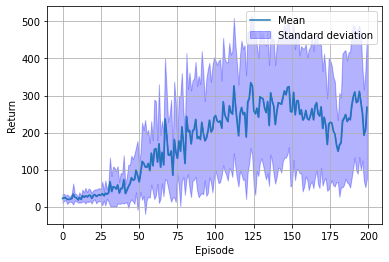

In [159]:
plot_learning_curve(w.n_episodes, runs_results)


In [132]:
def plot_slice(
    policy_net, q=True, cart_velocity=0, angle_range=0.2095, angle_samples=100, omega_range=1, omega_samples=100
):
    angles = torch.linspace(angle_range, -angle_range, angle_samples)
    omegas = torch.linspace(-omega_range, omega_range, omega_samples)

    greedy_q_array = torch.zeros((angle_samples, omega_samples))
    policy_array = torch.zeros((angle_samples, omega_samples))
    for i, angle in enumerate(angles):
        for j, omega in enumerate(omegas):
            state = torch.tensor([0.0, cart_velocity, angle, omega])
            with torch.no_grad():
                q_vals = policy_net(state)
                greedy_action = q_vals.argmax()
                greedy_q_array[i, j] = q_vals[greedy_action]
                policy_array[i, j] = greedy_action

    if q:
        plt.contourf(angles, omegas, greedy_q_array.T, cmap="cividis", levels=100)
        plt.colorbar()
    else:
        plt.contourf(angles, omegas, policy_array.T, cmap="cividis")
        cbar = plt.colorbar(ticks=[0, 1])
        cbar.ax.get_yaxis().set_ticklabels(["LEFT", "RIGHT"])

    plt.xlabel("Pole angle")
    plt.ylabel("Pole angular velocity")

    plt.show()


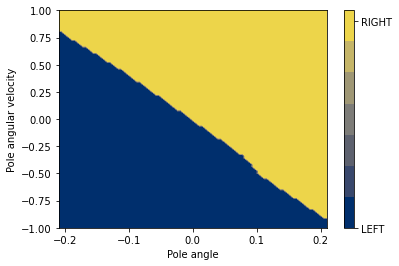

In [124]:
plot_slice(w.policy_net, q=False, cart_velocity=0)


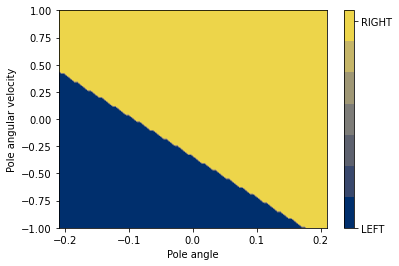

In [125]:
plot_slice(w.policy_net, q=False, cart_velocity=0.5)


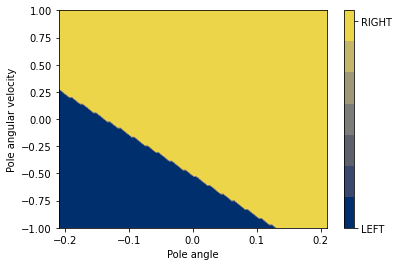

In [126]:
plot_slice(w.policy_net, q=False, cart_velocity=1)


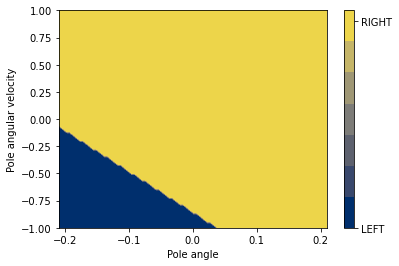

In [127]:
plot_slice(w.policy_net, q=False, cart_velocity=2)


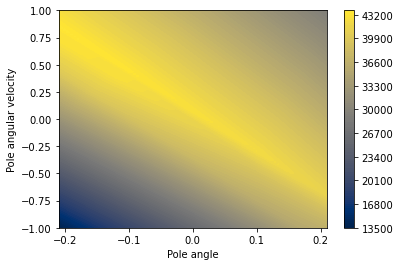

In [133]:
plot_slice(w.policy_net, q=True, cart_velocity=0)


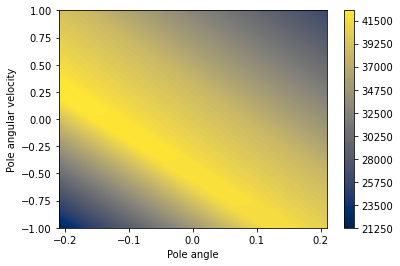

In [134]:
plot_slice(w.policy_net, q=True, cart_velocity=0.5)


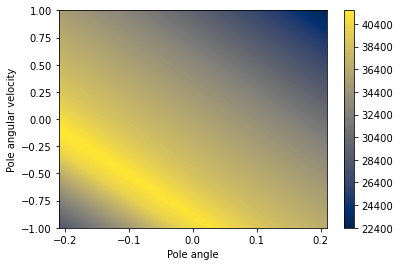

In [135]:
plot_slice(w.policy_net, q=True, cart_velocity=1)


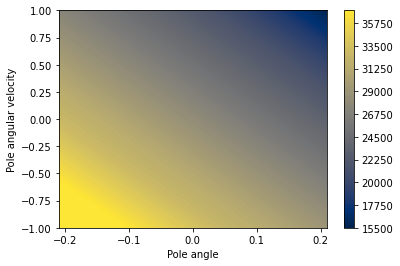

In [136]:
plot_slice(w.policy_net, q=True, cart_velocity=2)


In [ ]:
class HyperParamTuner:
    def __init__(
        self,
        epsilons=[1, 0.9, 0.5],
        epsilon_decays=[0.998, 0.988, 0.95],
        lrs=[0.4, 0.1, 0.04, 0.01, 0.004, 0.002, 0.001],
        optims=["Adam", "SGD"],
        memory_sizes=[100, 1000, 10000, 100000],
        neurons_list=[[4, 2], [4, 8, 2], [4, 8, 8, 2], [4, 16, 16, 2], [4, 32, 32, 2]],
        batch_sizes=[16, 32, 64, 128, 256],
    ):
        self.epsilons = epsilons
        self.epsilon_decays = epsilon_decays
        self.lrs = lrs
        self.optims = optims
        self.memory_sizes = memory_sizes
        self.neurons_list = neurons_list
        self.batch_sizes = batch_sizes

        self.hyperparams = dict()
        self.hyperparams["epsilons"] = self.epsilons
        self.hyperparams["epsilon_decays"] = self.epsilon_decays
        self.hyperparams["lrs"] = self.lrs
        self.hyperparams["optims"] = self.optims
        self.hyperparams["memory_sizes"] = self.memory_sizes
        self.hyperparams["neurons_list"] = self.neurons_list
        self.hyperparams["batch_sizes"] = self.batch_sizes

    def tune(self):
        results_list = []
        env = gym.make("CartPole-v1")

        for k, vs in self.hyperparams.items():
            for i in tqdm(range(len(vs))):
                param = {k: vs[i]}
                wrappedDQN = WrapperDQN(env=env, **param)
                results = wrappedDQN.run(verbose=False)
                results_list.append(results)
                self.plot_learning_curves(results_list, wrappedDQN.n_episodes, k, vs)
            results_list.clear()

    def plot_learning_curves(self, results_list, n_episodes, label, values):
        tensor_of_results = torch.tensor(results_list)

        for i, results in enumerate(tensor_of_results):
            means = results.float().mean(0)
            stds = results.float().std(0)

            plt.plot(torch.arange(n_episodes), means, label=f"{label} = {values[i]}")
            plt.ylabel("Return")
            plt.xlabel("Episode")
            #             plt.fill_between(np.arange(n_episodes), means, means+stds, alpha=0.3)
            #             plt.fill_between(np.arange(n_episodes), means, means-stds, alpha=0.3)

            plt.legend()

        plt.show()


In [170]:
tuner = HyperParamTuner()
tuner.tune()


In [163]:
ddqn = WrapperDQN(env=gym.make("CartPole-v1"), ddqn=True)


In [164]:
ddqn_results = ddqn.run()


Starting run 1 of 10
episode  50 / 200
episode  100 / 200
episode  150 / 200
episode  200 / 200
Starting run 2 of 10
episode  50 / 200
episode  100 / 200
episode  150 / 200
episode  200 / 200
Starting run 3 of 10
episode  50 / 200
episode  100 / 200
episode  150 / 200
episode  200 / 200
Starting run 4 of 10
episode  50 / 200
episode  100 / 200
episode  150 / 200
episode  200 / 200
Starting run 5 of 10
episode  50 / 200
episode  100 / 200
episode  150 / 200
episode  200 / 200
Starting run 6 of 10
episode  50 / 200
episode  100 / 200
episode  150 / 200
episode  200 / 200
Starting run 7 of 10
episode  50 / 200
episode  100 / 200
episode  150 / 200
episode  200 / 200
Starting run 8 of 10
episode  50 / 200
episode  100 / 200
episode  150 / 200
episode  200 / 200
Starting run 9 of 10
episode  50 / 200
episode  100 / 200
episode  150 / 200
episode  200 / 200
Starting run 10 of 10
episode  50 / 200
episode  100 / 200
episode  150 / 200
episode  200 / 200
Complete


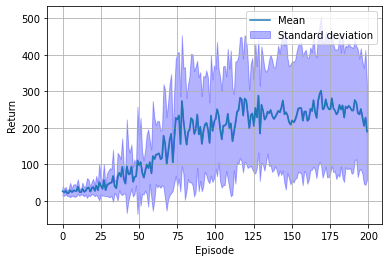

In [165]:
ddqn_runs_results = ddqn_results
plot_learning_curve(ddqn.n_episodes, ddqn_runs_results)


In [160]:
ddqn_results = torch.tensor(ddqn_runs_results)
dqn_results = torch.tensor(runs_results)

ddqn_means = ddqn_results.float().mean(0)
ddqn_stds = ddqn_results.float().std(0)
dqn_means = dqn_results.float().mean(0)
dqn_stds = dqn_results.float().std(0)

plt.plot(torch.arange(ddqn.n_episodes), ddqn_means)
plt.plot(torch.arange(w.n_episodes), dqn_means)

plt.ylabel("Return")
plt.xlabel("Episode")

plt.grid()

plt.fill_between(np.arange(ddqn.n_episodes), ddqn_means, ddqn_means+ddqn_stds, alpha=0.3, color='b')
plt.fill_between(np.arange(ddqn.n_episodes), ddqn_means, ddqn_means-ddqn_stds, alpha=0.3, color='b')
plt.fill_between(np.arange(w.n_episodes), dqn_means, dqn_means+dqn_stds, alpha=0.3, color='y')
plt.fill_between(np.arange(w.n_episodes), dqn_means, dqn_means-dqn_stds, alpha=0.3, color='y')

plt.legend(["DDQN mean", "DQN mean", "DDQN std", "DQN std"])


In [18]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it
